In [1]:
import pandas as pd
df = pd.read_csv('qatar_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:56:41.503000,VER,1,0 days 00:01:51.344000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:29.908000,...,True,Red Bull Racing,0 days 00:54:49.896000,2024-12-01 16:03:33.084,124,1.0,False,NaN,False,False
1,0 days 00:59:02.760000,VER,1,0 days 00:02:21.257000,2.0,1.0,NaN,NaN,0 days 00:00:55.914000,0 days 00:00:43.653000,...,True,Red Bull Racing,0 days 00:56:41.503000,2024-12-01 16:05:24.691,4,1.0,False,NaN,False,False
2,0 days 01:01:20.150000,VER,1,0 days 00:02:17.390000,3.0,1.0,NaN,NaN,0 days 00:00:51.955000,0 days 00:00:42.864000,...,True,Red Bull Racing,0 days 00:59:02.760000,2024-12-01 16:07:45.948,4,1.0,False,NaN,False,False
3,0 days 01:03:53.242000,VER,1,NaN,4.0,1.0,NaN,NaN,0 days 00:00:48.051000,0 days 00:00:42.711000,...,True,Red Bull Racing,0 days 01:01:20.150000,2024-12-01 16:10:03.338,41,1.0,False,NaN,False,False
4,0 days 01:05:19.966000,VER,1,0 days 00:01:26.724000,5.0,1.0,NaN,NaN,0 days 00:00:32.248000,0 days 00:00:29.054000,...,True,Red Bull Racing,0 days 01:03:53.242000,2024-12-01 16:12:36.430,12,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0 days 02:20:29.132000,PIA,81,0 days 00:01:23.523000,53.0,4.0,NaN,NaN,0 days 00:00:31.087000,0 days 00:00:28.409000,...,False,McLaren,0 days 02:19:05.609000,2024-12-01 17:27:48.797,1,3.0,False,NaN,False,True
939,0 days 02:21:52.502000,PIA,81,0 days 00:01:23.370000,54.0,4.0,NaN,NaN,0 days 00:00:31.143000,0 days 00:00:28.268000,...,False,McLaren,0 days 02:20:29.132000,2024-12-01 17:29:12.320,1,3.0,False,NaN,False,True
940,0 days 02:23:15.771000,PIA,81,0 days 00:01:23.269000,55.0,4.0,NaN,NaN,0 days 00:00:31.165000,0 days 00:00:28.214000,...,False,McLaren,0 days 02:21:52.502000,2024-12-01 17:30:35.690,1,3.0,False,NaN,False,True
941,0 days 02:24:39.084000,PIA,81,0 days 00:01:23.313000,56.0,4.0,NaN,NaN,0 days 00:00:31.161000,0 days 00:00:28.231000,...,False,McLaren,0 days 02:23:15.771000,2024-12-01 17:31:58.959,1,3.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 57  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              4              36.0              11.20   
1    ALO              3              36.0              14.25   
2    BOT              3              25.0              14.25   
3    COL              0               0.0               1.00   
4    GAS              3              36.0              14.25   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0             0.375          0.625000         0.000000  
1             0.000          0.982456         0.017544  
2             0.000          0.807018         0.192982  
3             0.000          1.000000         0.000000  
4             0.000          0.614035         0.385965  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,35.0,0 days 01:49:43.269000,NaN,MEDIUM,35.0,1.0
1,ALB,36.0,0 days 01:52:06.082000,0 days 01:50:12.541000,SOFT,1.0,2.0
2,ALB,37.0,0 days 01:54:03.427000,0 days 01:52:28.715000,SOFT,2.0,3.0
3,ALB,38.0,NaN,0 days 01:54:39.949000,SOFT,3.0,4.0
4,ALB,55.0,0 days 02:24:00.846000,NaN,SOFT,20.0,4.0
...,...,...,...,...,...,...,...
86,VER,38.0,NaN,0 days 01:54:01.640000,HARD,3.0,4.0
87,ZHO,35.0,0 days 01:49:20.658000,NaN,MEDIUM,35.0,1.0
88,ZHO,36.0,0 days 01:51:46.695000,0 days 01:49:50.432000,HARD,1.0,2.0
89,ZHO,37.0,0 days 01:53:54.687000,0 days 01:52:09.972000,HARD,2.0,3.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,4,36.0,11.200000,0.375000,0.625000,0.000000
1,ALO,3,36.0,14.250000,0.000000,0.982456,0.017544
2,BOT,3,25.0,14.250000,0.000000,0.807018,0.192982
3,COL,0,0.0,1.000000,0.000000,1.000000,0.000000
4,GAS,3,36.0,14.250000,0.000000,0.614035,0.385965
5,HAM,4,35.0,11.400000,0.000000,0.596491,0.403509
6,HUL,4,2.0,8.000000,0.000000,0.225000,0.775000
7,LAW,4,36.0,11.400000,0.298246,0.614035,0.087719
8,LEC,3,36.0,14.250000,0.000000,0.614035,0.385965
9,MAG,3,28.0,14.250000,0.000000,0.473684,0.526316


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,717


In [9]:
df['Driver'].value_counts()


,count
Driver,
VER,45
GAS,45
ALO,45
LEC,45
ZHO,45
TSU,45
LAW,45
SAI,44
PIA,44


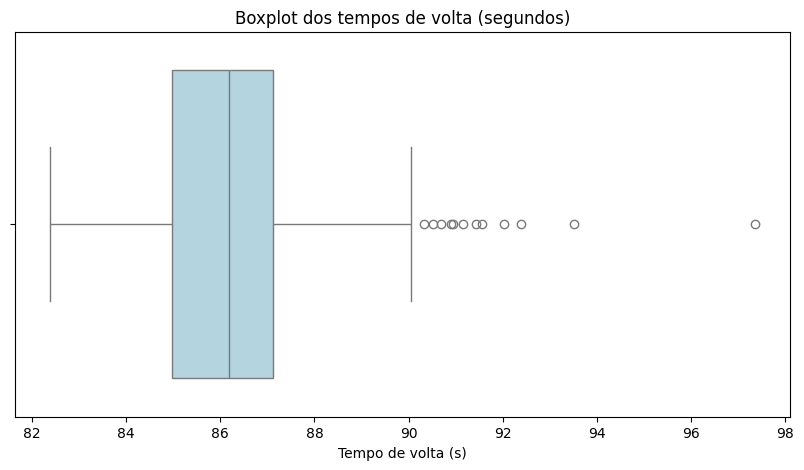

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


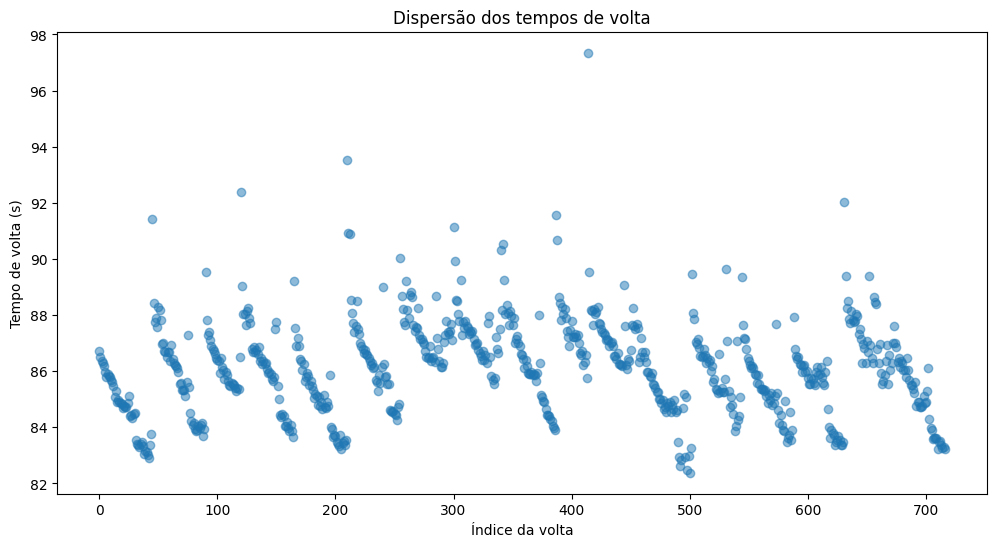

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


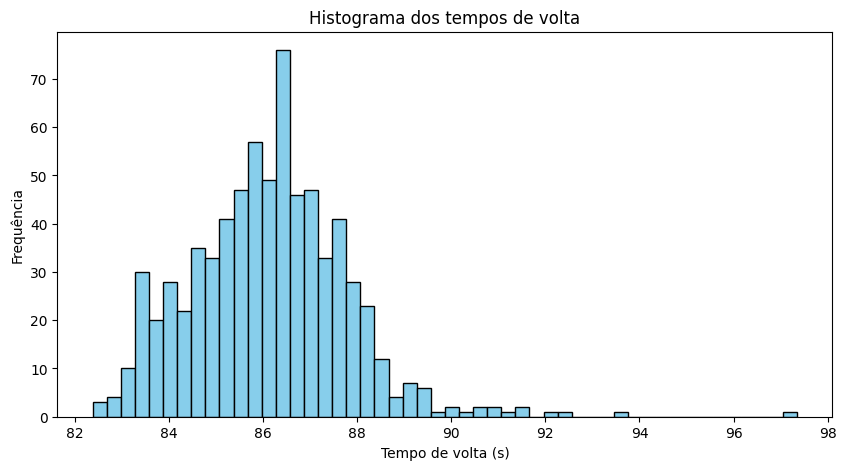

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


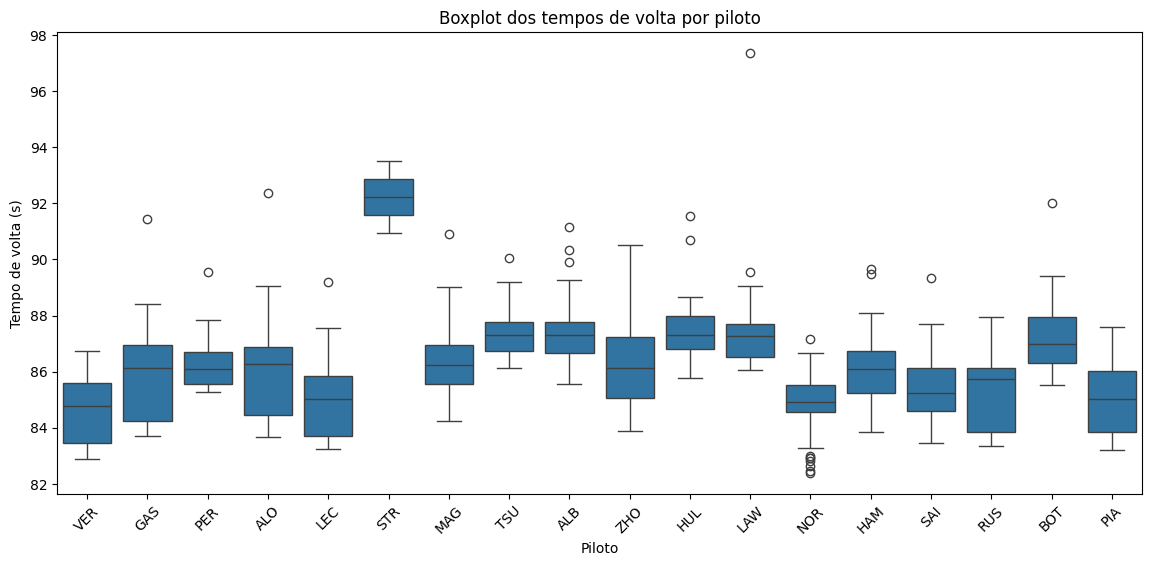

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
NOR   0 days 00:01:22.384000
VER   0 days 00:01:22.905000
PIA   0 days 00:01:23.218000
LEC   0 days 00:01:23.242000
RUS   0 days 00:01:23.355000
SAI   0 days 00:01:23.465000
ALO   0 days 00:01:23.667000
GAS   0 days 00:01:23.705000
HAM   0 days 00:01:23.865000
ZHO   0 days 00:01:23.889000
MAG   0 days 00:01:24.259000
PER   0 days 00:01:25.288000
BOT   0 days 00:01:25.533000
ALB   0 days 00:01:25.559000
HUL   0 days 00:01:25.767000
LAW   0 days 00:01:26.076000
TSU   0 days 00:01:26.144000
STR   0 days 00:01:30.935000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Catar'
race_date = '2024-12-01'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,42,87.389262,1.175000,85.559,91.146,87.3100,5.587,2024,Catar,2024-12-01
1,ALO,45,86.196067,1.721374,83.667,92.386,86.2680,8.719,2024,Catar,2024-12-01
2,BOT,42,87.280738,1.247955,85.533,92.024,86.9965,6.491,2024,Catar,2024-12-01
3,GAS,45,85.965311,1.636210,83.705,91.425,86.1200,7.720,2024,Catar,2024-12-01
4,HAM,42,86.064262,1.283930,83.865,89.654,86.1075,5.789,2024,Catar,2024-12-01
5,HUL,27,87.579407,1.244964,85.767,91.557,87.3000,5.790,2024,Catar,2024-12-01
6,LAW,45,87.475600,1.704579,86.076,97.350,87.2880,11.274,2024,Catar,2024-12-01
7,LEC,45,85.060289,1.320425,83.242,89.202,85.0360,5.960,2024,Catar,2024-12-01
8,MAG,43,86.318814,1.397368,84.259,90.890,86.2370,6.631,2024,Catar,2024-12-01
9,NOR,43,84.818070,1.201895,82.384,87.175,84.9150,4.791,2024,Catar,2024-12-01


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,42,87.389262,1.175000,85.559,91.146,87.3100,5.587,2024,Catar,2024-12-01,56.0,True
1,ALO,45,86.196067,1.721374,83.667,92.386,86.2680,8.719,2024,Catar,2024-12-01,57.0,True
2,BOT,42,87.280738,1.247955,85.533,92.024,86.9965,6.491,2024,Catar,2024-12-01,57.0,True
3,GAS,45,85.965311,1.636210,83.705,91.425,86.1200,7.720,2024,Catar,2024-12-01,57.0,True
4,HAM,42,86.064262,1.283930,83.865,89.654,86.1075,5.789,2024,Catar,2024-12-01,57.0,True
5,HUL,27,87.579407,1.244964,85.767,91.557,87.3000,5.790,2024,Catar,2024-12-01,40.0,False
6,LAW,45,87.475600,1.704579,86.076,97.350,87.2880,11.274,2024,Catar,2024-12-01,57.0,True
7,LEC,45,85.060289,1.320425,83.242,89.202,85.0360,5.960,2024,Catar,2024-12-01,57.0,True
8,MAG,43,86.318814,1.397368,84.259,90.890,86.2370,6.631,2024,Catar,2024-12-01,57.0,True
9,NOR,43,84.818070,1.201895,82.384,87.175,84.9150,4.791,2024,Catar,2024-12-01,57.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,4,36.0,11.200000,0.375000,0.625000,0.000000
1,ALO,3,36.0,14.250000,0.000000,0.982456,0.017544
2,BOT,3,25.0,14.250000,0.000000,0.807018,0.192982
3,COL,0,0.0,1.000000,0.000000,1.000000,0.000000
4,GAS,3,36.0,14.250000,0.000000,0.614035,0.385965
5,HAM,4,35.0,11.400000,0.000000,0.596491,0.403509
6,HUL,4,2.0,8.000000,0.000000,0.225000,0.775000
7,LAW,4,36.0,11.400000,0.298246,0.614035,0.087719
8,LEC,3,36.0,14.250000,0.000000,0.614035,0.385965
9,MAG,3,28.0,14.250000,0.000000,0.473684,0.526316


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,42,87.389262,1.175000,85.559,91.146,87.3100,5.587,2024,Catar,2024-12-01,56.0,True,4,36.0,11.200000,0.375000,0.625000,0.000000
1,ALO,45,86.196067,1.721374,83.667,92.386,86.2680,8.719,2024,Catar,2024-12-01,57.0,True,3,36.0,14.250000,0.000000,0.982456,0.017544
2,BOT,42,87.280738,1.247955,85.533,92.024,86.9965,6.491,2024,Catar,2024-12-01,57.0,True,3,25.0,14.250000,0.000000,0.807018,0.192982
3,GAS,45,85.965311,1.636210,83.705,91.425,86.1200,7.720,2024,Catar,2024-12-01,57.0,True,3,36.0,14.250000,0.000000,0.614035,0.385965
4,HAM,42,86.064262,1.283930,83.865,89.654,86.1075,5.789,2024,Catar,2024-12-01,57.0,True,4,35.0,11.400000,0.000000,0.596491,0.403509
5,HUL,27,87.579407,1.244964,85.767,91.557,87.3000,5.790,2024,Catar,2024-12-01,40.0,False,4,2.0,8.000000,0.000000,0.225000,0.775000
6,LAW,45,87.475600,1.704579,86.076,97.350,87.2880,11.274,2024,Catar,2024-12-01,57.0,True,4,36.0,11.400000,0.298246,0.614035,0.087719
7,LEC,45,85.060289,1.320425,83.242,89.202,85.0360,5.960,2024,Catar,2024-12-01,57.0,True,3,36.0,14.250000,0.000000,0.614035,0.385965
8,MAG,43,86.318814,1.397368,84.259,90.890,86.2370,6.631,2024,Catar,2024-12-01,57.0,True,3,28.0,14.250000,0.000000,0.473684,0.526316
9,NOR,43,84.818070,1.201895,82.384,87.175,84.9150,4.791,2024,Catar,2024-12-01,57.0,True,4,36.0,11.400000,0.000000,0.614035,0.385965


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (18, 19)
Pilotos presentes: 18


In [23]:
df_completo.to_csv('df_completoCatar.csv', index=False)
